In [2]:
import numpy as np
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import IPython

%load_ext autoreload
%autoreload 2
%matplotlib inline

def scale_data(vol, seg, size=180):
    length = vol.shape[0]
    vol = resize(vol, (length, size, size))
    seg = resize(seg, (length, size, size), order=0, preserve_range=True, anti_aliasing=False)

    return (vol, seg)
    
def label_data(vol, seg):
    length = vol.shape[0]
    x = vol.shape[1]
    y = vol.shape[2]
    # reshape for labeling
    seg = np.reshape(seg, (length, x*y) )
    vol = np.reshape(vol, (length, x*y) )
    # label
    labeled = color.label2rgb(seg, vol, alpha=0.1, bg_label=-1)
    # shape back
    labeled = np.reshape(labeled, (length, x, y, 3) )

    return labeled

def vis_volume(volume, fig_size=6.5):
    length = volume.shape[0]
    
    # set up
    fig = plt.figure()
    fig.set_size_inches(fig_size, fig_size)
    axes = fig.add_subplot()
    hfig = display(fig, display_id=True)

    # display
    for i in range(length):
        axes.imshow(volume[i], interpolation='none', filternorm=False, resample=False)
        fig.canvas.draw()
        hfig.update(fig)
        if i != length-1:
            plt.cla()
    # clean up
    IPython.display.clear_output()

def view_patch(patch,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(3,4)
    fig.set_size_inches(16, 10)
    axarr[0,0].imshow(patch.image[0][i], cmap='gray')
    axarr[0,1].imshow(patch.label[0][i], cmap='prism')
    axarr[0,2].imshow(label_data(patch.image[0],patch.label[0])[i])
    axarr[1,0].imshow(patch.affinity[0][i], cmap='gray')
    axarr[1,1].imshow(patch.affinity[1][i], cmap='gray')
    axarr[1,2].imshow(patch.affinity[2][i], cmap='gray')
    axarr[2,0].imshow(patch.get_lsd_channel(0)[i,:,:,0])
    axarr[2,1].imshow(patch.get_lsd_channel(1)[i,:,:,0])
    axarr[2,2].imshow(patch.get_lsd_channel(2)[i,:,:,0])
    axarr[2,3].imshow(patch.get_lsd_channel(3)[i], cmap='gray')
    plt.show()


def view_affinity(affinity,i=0):
    plt.rcParams['image.interpolation'] = 'nearest'
    fig, axarr = plt.subplots(1,3)
    fig.set_size_inches(24, 20)
    axarr[0].imshow(affinity[0][i], cmap='gray')
    axarr[1].imshow(affinity[1][i], cmap='gray')
    axarr[2].imshow(affinity[2][i], cmap='gray')
    plt.show()

In [2]:
from neutorch.dataset.affinity import Dataset
from neutorch.dataset.ground_truth_volume import *

dataset = Dataset('../../data', patch_size=(26,256,256), length=100)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

loading file sample_A...
loading file sample_B...
loading file sample_C...


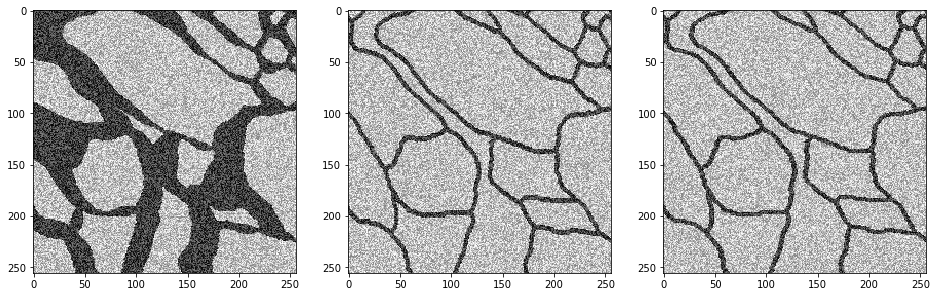

Re-using already compiled waterz version
Preparing segmentation volume...
(26, 256, 256) {'V_Rand_split': 0.9999960954913258, 'V_Rand_merge': 0.09816396174204572, 'V_Info_split': 2.2832357821300775e-05, 'V_Info_merge': 3.8745685388049727}
2


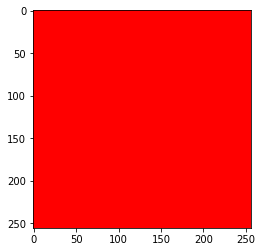

In [10]:
from waterz import agglomerate
import numpy as np

i = 5

patch = dataset.random_training_patch
affinity = patch.affinity
label = patch.label

# affs is a [3, z, y, x] numpy array of float32
affs = np.flip(affinity, axis=0)
affs = np.ascontiguousarray(affs, dtype=np.float32) 

ground_truth = np.ascontiguousarray(label[0], dtype=np.uint32) 
thresholds = [0.9]

affs += np.random.rand(*affs.shape)
view_affinity(affs,i=i)
seg_generator = agglomerate(affs, thresholds, gt=ground_truth,
       aff_threshold_low=0.1,
        aff_threshold_high=0.9,
        return_merge_history=True,
        return_region_graph=False)

for seg, metrics, merge_history in seg_generator:
        print(seg.shape, metrics)
        print(len(np.unique(seg)))
        plt.imshow(seg[i], cmap='prism')
        plt.show()


In [ ]:
from waterz import agglomerate
import numpy as np
from neutorch.cremi.neuron_ids import NeuronIds
import math

def get_agglo(affs, thresholds):

    print(affs.shape, affs.dtype)
    # flip so affinity channel is z,y,x NOT x,y,z
    affs = np.flip(affs, axis=0)
    affs = np.ascontiguousarray(affs, dtype=np.float32) 

    seg_generator = agglomerate(affs, thresholds,
            aff_threshold_low=0.001,
            aff_threshold_high=0.999,
            return_merge_history=False,
            return_region_graph=False)

    res = []
    for seg in seg_generator:
        cur = seg.copy()
        res.append(cur)

    return res


def cremi_test(test, truth, border_threshold):
    neuron_ids_evaluation = NeuronIds(truth, border_threshold=border_threshold)
    (voi_split, voi_merge) = neuron_ids_evaluation.voi(test)
    adapted_rand = neuron_ids_evaluation.adapted_rand(test)
    cremi_score = math.sqrt((voi_split + voi_merge) * adapted_rand) # the geometric mean of (VOI split + VOI merge) and ARAND.
    
    print(f'voi_split: {voi_split}, voi_merge: {voi_merge}, adapted_rand: {adapted_rand}')
    print(f'CREMI score: {cremi_score}')



In [3]:
patch = dataset.random_training_patch

affinity = patch.affinity
truth = np.squeeze(patch.label).astype(np.uint64)

thresholds = [0.1,0.7,1,10]
view_affinity(affinity)
tests = get_agglo(affinity, thresholds)

i=0
plt.imshow(truth[i], cmap='prism')
plt.show()
print(len(np.unique(truth)))
for test in tests:
    print(len(np.unique(test)))
    plt.imshow(test[i], cmap='prism')
    plt.show()
    cremi_test(test, truth, 1)
    

NameError: name 'dataset' is not defined

In [5]:
from neutorch.dataset.affinity import TestDataset
from neutorch.dataset.utils import from_h5
import numpy as np

dataset = TestDataset('../../data/sample_A_pad.hdf', (26,256,256), with_label=True)
label = dataset.label
(sz, sy, sx) = label.shape
(oz, oy, ox) = dataset.label_offset

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

loading from ../../data/sample_A_pad.hdf...


In [6]:
from neutorch.dataset.border_mask import create_border_mask
mask_size = 2
# add background mask
masked_label = np.zeros(label.shape, dtype=np.uint64)
create_border_mask(label, masked_label, 2, 0)
label = masked_label

In [7]:
t_classes, t_counts = np.unique(label, return_counts=True)
print(len(t_classes))

t_counts.sort()

9120


[       1        1        1 ...  2205764  2329106 27842743]
1703936


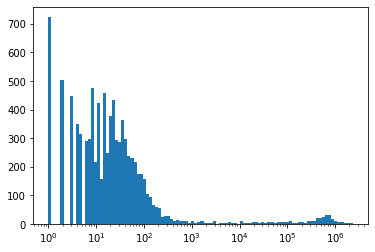

In [8]:
import matplotlib.pyplot as plt
import numpy as np


def plot_loghist(x, bins):
  hist, bins = np.histogram(x, bins=bins)
  logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
  plt.hist(x, bins=logbins)
  plt.xscale('log')



print(t_counts)
print(26*256*256)
filtered = list(filter(lambda x: x>10, t_counts))

plot_loghist(t_counts[:-1],100)
plt.show()



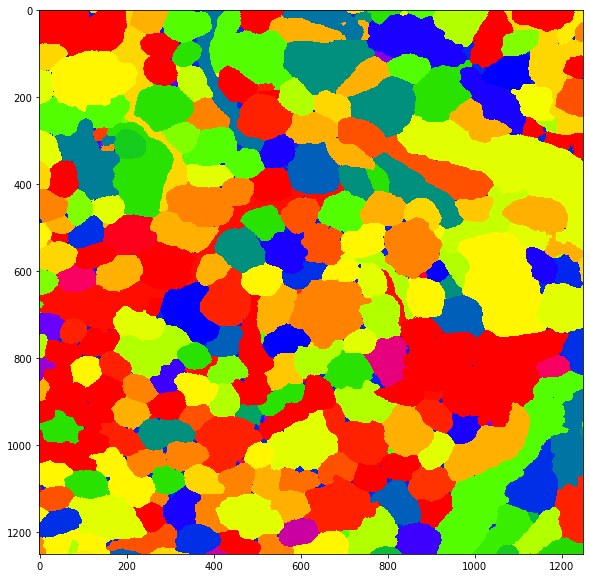

In [7]:
plt.rcParams['image.interpolation'] = 'nearest'
fig = plt.figure()
fig.set_size_inches(10, 10)
i=10
plt.imshow(label[i], cmap='prism')
plt.show()

In [2]:
swin_affs = np.load('../../run_swin/affinity.npy')
RSU_affs = np.load('../../run_RSUnet/affinity.npy')

In [3]:
from neutorch.dataset.utils import from_h5

path = '../../data'
file = 'sample_A'

image = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/raw')
label = from_h5(
f'{path}/{file}.hdf', dataset_path='volumes/labels/neuron_ids')

In [62]:
import numpy as np
import random
classes = []
cz, counts = np.unique(label, return_counts=True)
min_volume = 500
for i, c in enumerate(counts):
    if c > min_volume:
        classes.append(cz[i])


[  39  938 1172] [  59 1150 1249]


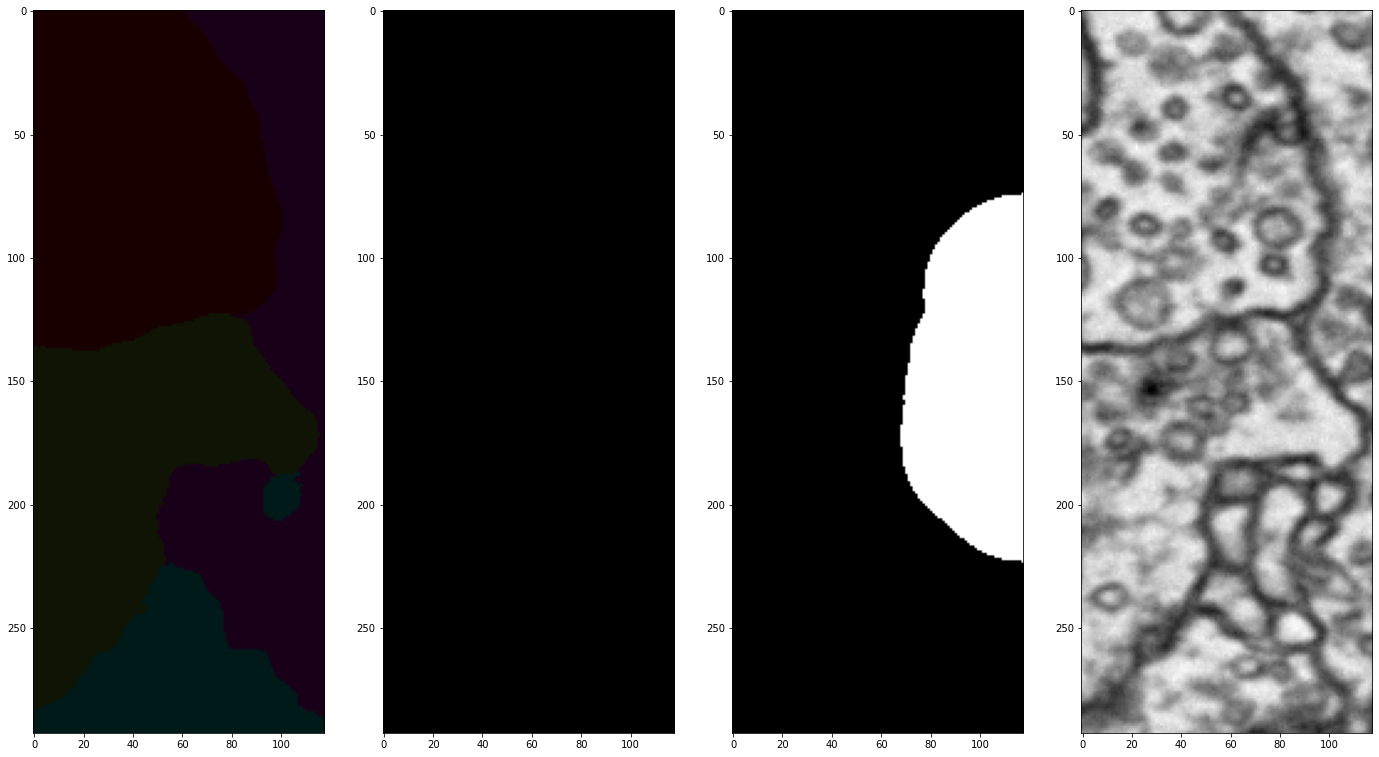

In [70]:
from skimage.segmentation import expand_labels

patch_size = (1,16,16)

c = random.choice(classes)
indices = np.argwhere(label == c)

mins = np.amin(indices,axis=0)
maxs = np.amax(indices,axis=0)
expd_amt = 40 # how much to expand the label for context is x,y

# convert ranges
border = (4, expd_amt, expd_amt)
vol_shape = (125, 1250, 1250)
print(mins, maxs)
for i in range(3):
    mins[i] = max(mins[i] - border[i], 0)
    maxs[i] = min(maxs[i] + border[i], vol_shape[i]-1)
    
# crop
crop_sl = np.s_[mins[0]:maxs[0]+1,mins[1]:maxs[1]+1,mins[2]:maxs[2]+1]
label_sec = label[crop_sl]
image_sec = image[crop_sl]
coord_sec = np.mgrid[crop_sl]

# add channel for coordinates
image_sec = np.expand_dims(image_sec, 0)
image_sec = np.concatenate((image_sec, coord_sec), axis=0)

# zero other classes
label_sec_b = np.zeros_like(label_sec)
label_sec_b[label_sec == c] = c

expanded = np.zeros_like(label_sec)
# expand label in z,y
for i in range(label_sec_b.shape[2]):
    expanded[:,:,i] = expand_labels(label_sec_b[:,:,i], border[0]//2)

# expand label in z,x
for i in range(expanded.shape[1]):
    expanded[:,i,:] = expand_labels(expanded[:,i,:], border[0]//2)

# expand label in x,y
for i in range(expanded.shape[0]):
    expanded[i,:,:] = expand_labels(expanded[i,:,:], border[1]-border[0])
    


# view
fig, axarr = plt.subplots(1,4)
fig.set_size_inches(24, 20)
i = label_sec.shape[0] //2
i = 0
axarr[0].imshow(label_data(image_sec[0], label_sec)[i])
axarr[1].imshow(label_sec_b[i], cmap='gray')
axarr[2].imshow(expanded[i], cmap='gray')
axarr[3].imshow(image_sec[0, i], cmap='gray')



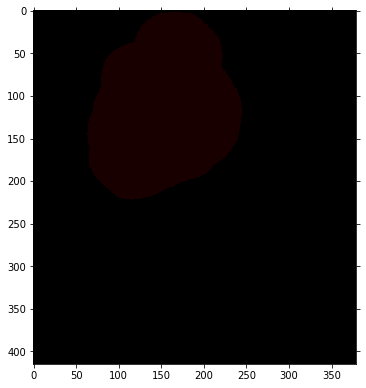

In [136]:
vis_volume(label_data(image_sec[0], expanded))

In [137]:
from einops import rearrange
import math


def patchify(vol, patch_size):
    
    # pad, could do so we pad wth actual data is possible
    vol_shape = vol.shape
    pad_width = []
    for i in range(len(patch_size)):
        left = vol_shape[i] % patch_size[i]
        if left > 0:
            add = patch_size[i] - left
            pad_width.append((math.floor(add/2),math.ceil(add/2)))
        else:
            pad_width.append((0,0))
    padded = np.pad(vol, pad_width)
    vol_shape = padded.shape

    # check
    assert vol_shape[-1] % patch_size[-1] == 0 and vol_shape[-2] % patch_size[-2]== 0 and vol_shape[-3] % patch_size[-3]== 0, 'Image dimensions must be divisible by the patch size.'

    # patch
    pz, py, px = patch_size[-3:]
    arr = rearrange(padded, 'c (z pz) (y py) (x px) -> (z y x) c pz py px', pz=pz, py=py, px=px)
   
    return arr

# drop zero patches
# assumes image_arr and label_arr are in corresponding order
def drop_patches_without_label(image_arr, label_arr, c):
    drop_arr = []
    for i in range(label_arr.shape[0]):
        if c in label_arr[i]:
            drop_arr.append(image_arr[i])
    return np.array(drop_arr)


(78000, 4, 1, 16, 16) (78000, 1, 1, 16, 16)
(17218, 4, 1, 16, 16)


<Figure size 432x288 with 0 Axes>

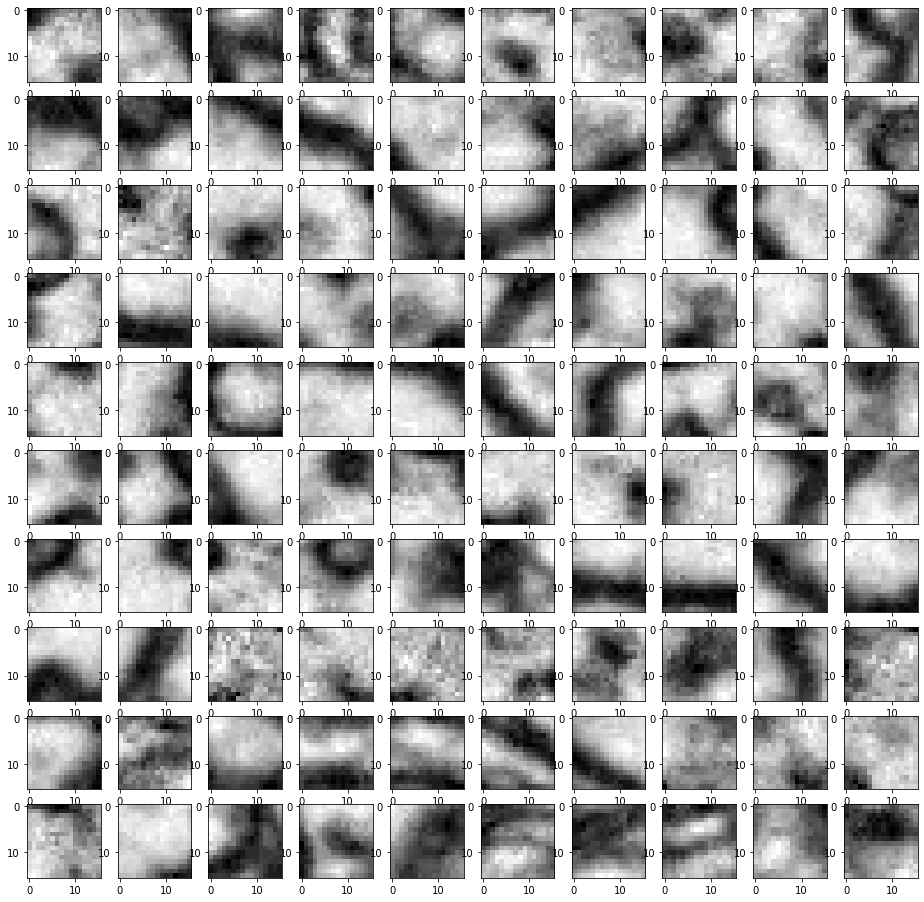

In [138]:
image = image_sec.copy()
label = np.expand_dims(expanded.copy(),0)
combined = np.concatenate((image, label), 0)
combined_arr = patchify(combined, (1, *patch_size))
image_arr = combined_arr[:,:-1,...]
label_arr = combined_arr[:,-1:,...]
print(image_arr.shape, label_arr.shape)
image_arr = drop_patches_without_label(image_arr, label_arr, c)
print(image_arr.shape)
fig = plt.figure()
fig, axarr = plt.subplots(10,10)
fig.set_size_inches(16, 16)
for i in range(0,10):
    for j in range(0,10):
        axarr[i,j].imshow(image_arr[(i*10)+j][0][0], cmap='gray')
plt.show()

In [75]:
recon = np.zeros((125+1,1250+16,1250+16))

for i in range(image_arr.shape[0]):
    patch = image_arr[i]
    val = patch[0]
    sz = val.shape
    coors = patch[1:]
    st = coors[:,0,0,0].astype(int)
    recon[st[0]:st[0]+sz[0],st[1]:st[1]+sz[1],st[2]:st[2]+sz[2]] = val

vis_volume(recon)

NameError: name 'image_arr' is not defined

In [4]:
from neutorch.dataset.utils import from_h5
from neutorch.dataset.proofread import ProofreadDataset

path = '../../data'
file = 'sample_A'

image = from_h5(f'{path}/{file}.hdf', dataset_path='volumes/raw')
true_label = from_h5(
f'{path}/{file}.hdf', dataset_path='volumes/labels/neuron_ids')
pred_label = np.load('../../swin_run/segmentation_700000_sample_A_pad.npy')


If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [57]:
import h5py

with h5py.File('../../swin_run/segmentation_700000_sample_A_pad.h5', 'w') as hf:
    hf.create_dataset("seg",  data=pred_label)

In [43]:

dataset = ProofreadDataset(image, pred_label, true_label, name=file)


In [53]:
img, lbl = dataset[43]

[   0    0 1051] [   2    8 1074]
(slice(0, 7, None), slice(0, 49, None), slice(1011, 1115, None))
expand
_patchify
drop_p


In [54]:
print(img.shape, lbl.shape)

(166, 4, 1, 16, 16) (166, 1, 1, 16, 16)


In [55]:

recon = np.zeros((125+1,1250+16,1250+16))
recon_label = np.zeros((125+1,1250+16,1250+16, 3))
for j in range(img.shape[0]):
    patch = img[j]
    seg = lbl[j][0]
    val = patch[0]
    sz = val.shape
    coors = patch[1:]
    st = coors[:,0,0,0].astype(int)
    
    recon[st[0]:st[0]+sz[0],st[1]:st[1]+sz[1],st[2]:st[2]+sz[2]] = val

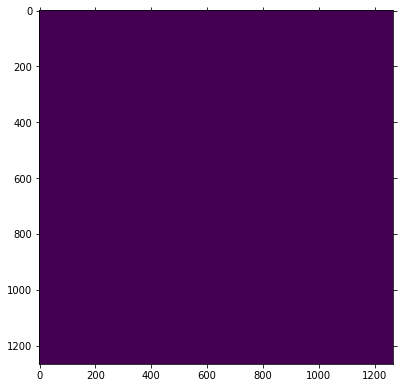

In [56]:
vis_volume(recon)

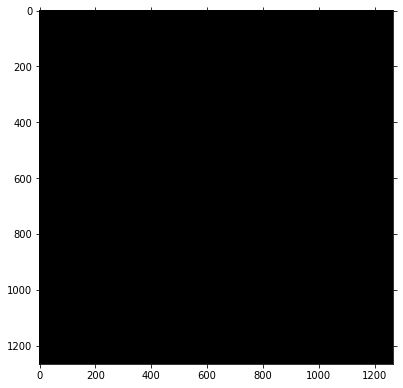

In [72]:
vis_volume(recon_label)